In [2]:
import pickle
import glob
import re
import os
import copy
import subprocess
import time
from datetime import datetime, timedelta, date
from collections import defaultdict, Counter, OrderedDict
from functools import reduce
import json
import vcf
import pysam
import numpy as np
import pandas as pd
import dask.dataframe as dd
from Bio import SeqIO
from Bio.SeqUtils import seq1
from Bio.Seq import Seq
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1 import make_axes_locatable
import random

from utils.file_loaders import load_metadata, load_vdb_mutation_data, merge_data, load_vdb_df, load_alias_data
from utils.quaid_func import get_counts, get_all_voc, build_count_df, get_recent_nt_df

In [3]:
def remove_ambiguous_snps(x):
    if isinstance(x, Counter):
        if '' in x:
            del x['']

        to_remove = Counter()
        for key in x:
            if re.match('[A,C,T,G][0-9]+[A,C,T,G,-]+', key) is None:
                to_remove[key] = x[key] 

        x = x - to_remove
        
        return +x
    else:
        return None

# Metadata

In [4]:
"""
if databases have been build, then set prebuild=True to load them directly
the lastest version of the database is built with max_date="2022-05-09"
"""
prebuild = True
max_date = "2022-10-21"

In [5]:
metadata_f = "/home/Users/ns58/SARS-CoV-2-MSA-10-21-2022/metadata.tsv"
vdb_df_path = "/home/Users/ns58/WW/vdb_output/vdb_lineage_df_week.csv"
trimmed_vdb_f = "/home/Users/ns58/SARS-CoV-2-MSA-10-21-2022/vdb_10212022_trimmed_nucl.txt"

In [6]:
def load_metadata(path):
    #logger.info(f'Loading {path}')
    _metadata = pd.read_csv(path, sep='\t', low_memory=False)
    _metadata = _metadata[(_metadata['Is complete?'] == True) & (_metadata['Host'] == 'Human')]
    _metadata = _metadata[['Pango lineage', 'Collection date', 'Accession ID', 'Location']].copy()
    _metadata = _metadata[_metadata['Collection date'].str.len() == 10].copy()
    _metadata['Collection date'] = pd.to_datetime(_metadata['Collection date'])
    _metadata = _metadata[_metadata['Pango lineage'].notna()].copy()
    _metadata = _metadata[_metadata['Pango lineage'] != 'None'].copy()
    _metadata = _metadata.set_index(['Collection date'])
    return _metadata

In [7]:
%%time
metadata = load_metadata(metadata_f)

CPU times: user 2min 49s, sys: 49 s, total: 3min 38s
Wall time: 3min 38s


In [8]:
%%time
vdb_df = load_vdb_df(vdb_df_path)

CPU times: user 52.8 s, sys: 4.91 s, total: 57.8 s
Wall time: 57.9 s


In [9]:
vdb_df = vdb_df.reset_index()

In [10]:
vdb_df

,Pango lineage,Collection date,SNPs
0,A,2019-12-30,"{'T4946C': 1, 'C8782T': 1, 'T28144C': 1, '': 1}"
1,A,2020-01-06,"{'C8782T': 2, 'T28144C': 2, '': 2, 'C5812Y': 1..."
2,A,2020-01-13,"{'C8782T': 3, 'T28144C': 3, 'C29095T': 3, '': ..."
3,A,2020-01-20,"{'C8782T': 14, 'T28144C': 14, '': 6, 'C18060T'..."
4,A,2020-01-27,"{'C8782T': 72, 'T28144C': 72, 'C18060T': 11, '..."
...,...,...,...
80530,Z.1,2021-03-29,"{'C241T': 2, 'T445C': 2, 'T2489C': 2, 'C3037T'..."
80531,Z.1,2021-04-05,"{'C241T': 2, 'T445C': 2, 'T2489C': 2, 'C3037T'..."
80532,Z.1,2021-04-12,"{'T11C': 1, 'A12T': 1, 'A14G': 1, 'C16G': 1, '..."
80533,Z.1,2021-04-19,"{'C241T': 1, 'T445C': 1, 'T2489C': 1, 'C3037T'..."


In [11]:
vdb_df['SNPs'] = vdb_df['SNPs'].map(remove_ambiguous_snps)

# Lineage Count

In [12]:
gisaid_total_count = metadata.shape[0]
gisaid_total_count

12988493

In [13]:
pango_count_df = pd.DataFrame(metadata.groupby(['Pango lineage'])['Pango lineage'].count())

In [14]:
pango_count_df = pango_count_df.rename({'Pango lineage': 'Count'}, axis=1)

# Anchon Calculation

In [15]:
pango_snps_dict = dict()
for pango_lineage in pango_count_df.index:
    vdb_df_temp = vdb_df[vdb_df['Pango lineage'] == pango_lineage]
    counter_list = [x for x in vdb_df_temp['SNPs'].to_list() if isinstance(x, Counter)] 
    pango_snps_dict[pango_lineage] = sum(counter_list, Counter())

In [16]:
quarc_db_path = 'quarc_dbs_01102023_incl_recombinant'
file_to_read = open(os.path.join(quarc_db_path, "mutation0_lookup.pkl"), "rb")
mutation0_lookup = pickle.load(file_to_read)
file_to_read = open(os.path.join(quarc_db_path, "mutation50_lookup.pkl"), "rb")
mutation50_lookup = pickle.load(file_to_read)

In [17]:
output_acc_id = False

In [18]:
test_set = set('A29039T;G29049A;G29050A'.split(";"))

In [19]:
test_set = set('C23604A;C23625T;C23638T;T23765G'.split(";"))

In [20]:
def search_anchors(mutation, mutation_lookup):
    anchor_set = set()
    try:
        for lineage in {item.split("/")[0] for item in mutation_lookup[mutation]}:
            try:
                prvalence_rate = pango_snps_dict[lineage][mutation]/pango_count_df.loc[lineage]['Count']
                if prvalence_rate >= 0.500:
                    anchor_set.add(lineage)
                    #print(mutation, lineage, prvalence_rate)
            except KeyError:
                continue
    except KeyError:
        return anchor_set
    return anchor_set

In [21]:
def calc_category(anchor_list, highest_lineage):
    all_anchor = True
    no_anchor = True

    for anchors in anchor_list:
        if len(anchors) > 0:
            no_anchor = False
        else:
            all_anchor = False

    if not no_anchor and not all_anchor:
        if highest_lineage != None:
            return 'ANCHOR,RARE'
        else:
            return 'ANCHOR,NOVAL'
        
    if no_anchor:
        if highest_lineage != None:
            return 'NO_ANCHOR,RARE'
        else:
            return 'NO_ANCHOR,NOVAL'
    
    if all_anchor:
        if highest_lineage != None:
            return 'RECOMB,RARE'
        else:
            return 'RECOMB,NOVAL'

In [22]:
def quary_mutation_set(test_set):
    possible_voc_sets = []
    anchor_list = []
    for mutation in test_set:
        anchor_list.append(search_anchors(mutation, mutation50_lookup))
        try:
            possible_voc_sets.append(mutation0_lookup[mutation])
        except KeyError:
            possible_voc_sets.append(set())

    lineage_date_combs = set.intersection(*possible_voc_sets)
    anchor_intersection = set.intersection(*anchor_list)
    
    # if len(anchor_intersection) != 0:
    #     print('Error', anchor_intersection, test_set)
    #print(possible_voc_sets)

    mutation_prevalence_dict = defaultdict(int)
    for lineage_date_comb in lineage_date_combs:
        lineage, _ = lineage_date_comb.split("/")
        try:
            for acc_id in genome2snp_dict[lineage_date_comb]:
                if test_set.issubset(genome2snp_dict[lineage_date_comb][acc_id]):
                    if output_acc_id:
                        print(acc_id)
                    mutation_prevalence_dict[lineage] += 1
        except KeyError:
            continue

    mutation_prate_dict = defaultdict(float)
    for lineage in mutation_prevalence_dict:
        try:
            mutation_prate_dict[lineage] = mutation_prevalence_dict[lineage]/pango_count_df.loc[lineage]['Count']
            #print(lineage, mutation_prevalence_dict[lineage], pango_count_df.loc[lineage]['Count'])
        except KeyError:
            continue
            print(f"{lineage} not in pango_count_df")
            
    try:
        highest_lineage = max(mutation_prate_dict, key=lambda x:mutation_prate_dict[x])
    except ValueError:
        highest_lineage = None
    
    category = calc_category(anchor_list, highest_lineage)
    
    # if category == 'RECOMB,NOVAL':
    #     print(anchor_list)
    
    return category, highest_lineage, mutation_prate_dict[highest_lineage]

In [42]:
result_list = []
for mutation, row in incl_selected_data.iterrows():
    category, highest_lineage, prev = quary_mutation_set(set(mutation.split(';')))
    aa_mutation = incl_merged_df[incl_merged_df['Nt Mutations'] == mutation]['AA Mutations'].unique()[0]
    result_list.append({
        'Nt Mutation': mutation,
        'AA Mutation': aa_mutation,
        'Category': category,
        'Highest Lineage': highest_lineage,
        'Highest Prev Rate': prev
    })

In [43]:
result_df = pd.DataFrame(result_list)

In [44]:
highest_occ = []
for idx, row in result_df.iterrows():
    nt_mutation = row['Nt Mutation']
    highest_lineage = row['Highest Lineage']
    
    highest_occ.append(incl_query_result[nt_mutation][highest_lineage])

In [45]:
result_df['Highest Occ'] = highest_occ

In [46]:
result_df = result_df.merge(selected_data, how='left', left_on = 'Nt Mutation', right_index=True)

In [47]:
result_df['Lineage Purity'] = result_df['Highest Occ']/result_df['GISAID Count']

In [48]:
result_df.to_csv('recombinant.csv', index=False)

In [49]:
result_df = pd.read_csv('recombinant.csv')

In [50]:
result_df

,Nt Mutation,AA Mutation,Category,Highest Lineage,Highest Prev Rate,Highest Occ,Site,GISAID Count,Lineage Purity
0,A1003G;C913T,ORF1a:E246E;ORF1a:S216S,"ANCHOR,RARE",B.1.1.7,0.000083,95,5,95,1.000000
1,A10195G;C10252T,ORF1a:E3310E;ORF1a:F3329F,"ANCHOR,RARE",AY.42,0.000066,2,9,14,0.142857
2,A10195G;C10277T,ORF1a:E3310E;ORF1a:L3338F,"ANCHOR,RARE",B.1.1.7,0.000028,32,3,33,0.969697
3,A10195G;C10319T,ORF1a:E3310E;ORF1a:L3352F,"ANCHOR,RARE",B.1.2,0.000007,1,7,3,0.333333
4,A10195G;C10332T,ORF1a:E3310E;ORF1a:T3356I,"ANCHOR,RARE",B.1.1.7,0.000011,12,2,12,1.000000
...,...,...,...,...,...,...,...,...,...
711,T7233G;A7234T;G7235T,ORF1a:L2323*;ORF1a:L2323F;ORF1a:V2324F,"NO_ANCHOR,NOVAL",NaN,0.000000,0,2,0,NaN
712,T847A;C913T,ORF1a:D194E;ORF1a:S216S,"ANCHOR,RARE",B.1.1.7,0.000256,292,10,293,0.996587
713,T886C;C913T,ORF1a:R207R;ORF1a:S216S,"ANCHOR,RARE",B.1.1.7,0.000062,71,2,71,1.000000
714,T8915C;C8986T,ORF1a:F2884L;ORF1a:D2907D,"ANCHOR,RARE",AY.102,0.001842,5,3,120,0.041667


In [51]:
result_df[(result_df['Category'] == 'RECOMB,RARE') & (result_df['Lineage Purity'] <= 1)].sort_values(by=['Site'])

,Nt Mutation,AA Mutation,Category,Highest Lineage,Highest Prev Rate,Highest Occ,Site,GISAID Count,Lineage Purity
356,C6312A;C6402T,ORF1a:T2016K;ORF1a:P2046L,"RECOMB,RARE",AY.46.6.1,0.005495,1,2,542,0.001845
452,G25135T;G25337T,S:K1191N;S:D1259Y,"RECOMB,RARE",AY.4.5,0.005817,99,2,109,0.908257
445,G24781T;G24914C,S:K1073N;S:D1118H,"RECOMB,RARE",Q.1,0.000582,4,2,440,0.009091
441,G23522C;G23593T,S:E654Q;S:Q677H,"RECOMB,RARE",B.1.2,0.000471,69,2,85,0.811765
418,G18984T;C19220T,ORF1b:M1839I;ORF1b:A1918V,"RECOMB,RARE",AY.1,0.011871,42,2,714,0.058824
...,...,...,...,...,...,...,...,...,...
492,G28326T;C28432T,N:G18V;N:F53F,"RECOMB,RARE",BE.1.1.2,0.000199,1,9,26,0.038462
543,G29050A;C29149T,N:R259R;N:I292I,"RECOMB,RARE",AY.3.1,0.001558,26,9,123,0.211382
112,A29301G;G29402T,N:D343G;N:D377Y,"RECOMB,RARE",B.1.1.529,0.025224,45,22,278,0.161871
684,T28382C;C28432T,N:S37P;N:F53F,"RECOMB,RARE",B.1.1.1,0.002249,7,50,68,0.102941


In [52]:
#quary_mutation_set({'A29301G', 'G29402T'})

In [53]:
incl_merged_df[incl_merged_df['Nt Mutations'] == 'A29301G;G29402T']

,Date,Site,Nt Mutations,AA Mutations,Support DP,Total DP,Combined Freq
19,2022-01-06,IA,A29301G;G29402T,N:D343G;N:D377Y,6,406,0.014778
11060,2021-12-23,76,A29301G;G29402T,N:D343G;N:D377Y,26,1856,0.014009
11084,2021-12-23,CD,A29301G;G29402T,N:D343G;N:D377Y,65,1213,0.053586
11106,2021-12-23,EH,A29301G;G29402T,N:D343G;N:D377Y,35,2949,0.011868
11122,2021-12-23,FC,A29301G;G29402T,N:D343G;N:D377Y,88,3445,0.025544
11123,2021-12-23,GR,A29301G;G29402T,N:D343G;N:D377Y,14,1283,0.010912
11153,2021-12-23,HO,A29301G;G29402T,N:D343G;N:D377Y,123,2568,0.047897
11162,2021-12-23,IV,A29301G;G29402T,N:D343G;N:D377Y,42,1239,0.033898
11170,2021-12-23,KW,A29301G;G29402T,N:D343G;N:D377Y,59,3367,0.017523
11174,2021-12-23,KWW,A29301G;G29402T,N:D343G;N:D377Y,111,2457,0.045177


In [54]:
bar_df = pd.DataFrame(result_df.groupby(['Category'])['Category'].count())
bar_df

,Category
Category,
"ANCHOR,NOVAL",72
"ANCHOR,RARE",476
"NO_ANCHOR,NOVAL",18
"NO_ANCHOR,RARE",26
"RECOMB,NOVAL",3
"RECOMB,RARE",121


In [56]:
bar_df.sum()

Category    716
dtype: int64

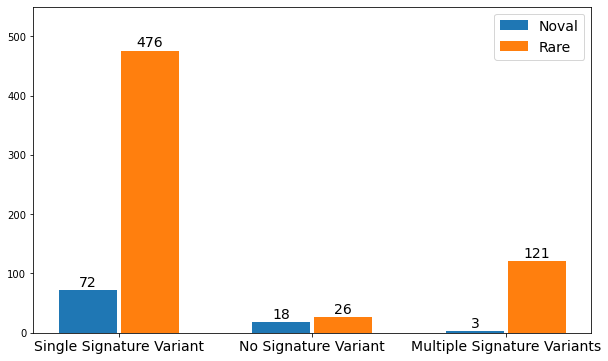

In [57]:
fontsize = 14
fig, ax  = plt.subplots(1, 1, figsize=(10, 6))

x_axis = np.arange(len(bar_df.index)/2)

bar1 = ax.bar(x_axis-0.16, bar_df['Category'].values[0::2], width=0.3, label='Noval')
bar2 = ax.bar(x_axis+0.16, bar_df['Category'].values[1::2], width=0.3, label='Rare')

labels = ['Single Signature Variant', 'No Signature Variant', 'Multiple Signature Variants']

ax.set_xticks(x_axis)
ax.set_xticklabels(labels, fontsize=fontsize)
ax.set_ylim(0,550)

for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.0f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=fontsize, xytext=(0, 8),
                   textcoords='offset points')

ax.legend(fontsize=fontsize)

## RECOMB,NOVAL

In [ ]:
for mutation, row in excl_selected_data[excl_selected_data['GISAID Count'] <= 0].sort_values(['Mutation Occurance'], ascending=False).iterrows():
    category, highest_lineage, prev = quary_mutation_set(set(mutation.split(';')))
    
    if category == 'RECOMB,NOVAL':
        print(mutation, '\t', excl_merged_df[excl_merged_df['Nt Mutations'] == mutation]['AA Mutations'].unique(), '\t', category, '\t', highest_lineage, '\t', prev)

### ORF1b:P314C

In [459]:
excl_merged_df[excl_merged_df['Nt Mutations'] == 'A28870T;G28881A;G28916T']

,Date,Site,Nt Mutations,AA Mutations,Support DP,Total DP,Combined Freq
4914,2022-05-19,KB,A28870T;G28881A;G28916T,N:P199P;N:R203K;N:G215C,36,460,0.078261
6163,2022-07-14,KB,A28870T;G28881A;G28916T,N:P199P;N:R203K;N:G215C,34,692,0.049133
7889,2022-09-02,KB,A28870T;G28881A;G28916T,N:P199P;N:R203K;N:G215C,32,791,0.040455


In [458]:
excl_merged_df[excl_merged_df['Nt Mutations'] == 'C14407T;C14408G']

,Date,Site,Nt Mutations,AA Mutations,Support DP,Total DP,Combined Freq
2378,2021-03-22,KWW,C14407T;C14408G,ORF1b:P314S;ORF1b:P314R,112,1284,0.087227
4560,2021-05-10,KWW,C14407T;C14408G,ORF1b:P314S;ORF1b:P314R,182,874,0.208238


In [460]:
excl_merged_df[excl_merged_df['Nt Mutations'] == 'C2061T;T2158A']

,Date,Site,Nt Mutations,AA Mutations,Support DP,Total DP,Combined Freq
8845,2021-09-27,HO,C2061T;T2158A,ORF1a:A599V;ORF1a:L631L,15,271,0.055351
9273,2021-10-11,HO,C2061T;T2158A,ORF1a:A599V;ORF1a:L631L,14,437,0.032037


## ANCHOR,NOVAL / NO_ANCHOR,NOVAL

In [491]:
count = 0
for mutation, row in excl_selected_data[excl_selected_data['GISAID Count'] <= 0].sort_values(['Mutation Occurance'], ascending=False).iterrows():
    category, highest_lineage, prev = quary_mutation_set(set(mutation.split(';')))
    
    if category == 'ANCHOR,NOVAL':
        count += 1
        
    if category == 'NO_ANCHOR,NOVAL':
        print(mutation, '\t', excl_merged_df[excl_merged_df['Nt Mutations'] == mutation]['AA Mutations'].unique(), '\t', category, '\t', highest_lineage, '\t', prev)
        
    if 'NOVAL' not in category:
        print()
        print(mutation, '\t', excl_merged_df[excl_merged_df['Nt Mutations'] == mutation]['AA Mutations'].unique(), '\t', category, '\t', highest_lineage, '\t', prev)
        print()

C15805A;A15812T 	 ['ORF1b:Q780K;ORF1b:N782I'] 	 NO_ANCHOR,NOVAL 	 None 	 0.0
T689A;C690A;T692C;T693C 	 ['ORF1a:S142T;ORF1a:S142*;ORF1a:F143L;ORF1a:F143S'] 	 NO_ANCHOR,NOVAL 	 None 	 0.0
G18379A;T18446G 	 ['ORF1b:G1638S;ORF1b:V1660G'] 	 NO_ANCHOR,NOVAL 	 None 	 0.0
G28881C;G28895A 	 ['N:R203T;N:A208T'] 	 NO_ANCHOR,NOVAL 	 None 	 0.0
G27047C;G27147A 	 ['M:T175T;M:D209N'] 	 NO_ANCHOR,NOVAL 	 None 	 0.0
G24197A;C24374A 	 ['S:A879T;S:L938I'] 	 NO_ANCHOR,NOVAL 	 None 	 0.0
G18379A;T18510C 	 ['ORF1b:G1638S;ORF1b:L1681L'] 	 NO_ANCHOR,NOVAL 	 None 	 0.0
A10195G;G10290T 	 ['ORF1a:E3310E;ORF1a:G3342V'] 	 NO_ANCHOR,NOVAL 	 None 	 0.0
G688A;T689G;T692C;T693A 	 ['ORF1a:K141K;ORF1a:S142A;ORF1a:F143L;ORF1a:F143Y'] 	 NO_ANCHOR,NOVAL 	 None 	 0.0
T689A;C690A;T692C;T693C;G881T 	 ['ORF1a:S142T;ORF1a:S142*;ORF1a:F143L;ORF1a:F143S;ORF1a:A206S'] 	 NO_ANCHOR,NOVAL 	 None 	 0.0

T27835C;G28048A 	 ['ORF7b:I27T;ORF8:R52K'] 	 ANCHOR,RARE 	 XB 	 0.003235294117647059

T14233C;T14247C 	 ['ORF1b:Y256H;ORF1b:D260D'] 	

In [467]:
count/excl_selected_data[excl_selected_data['GISAID Count'] <= 0].shape[0]

0.7684210526315789

In [490]:
count

73

In [41]:
def mutation_comb_msa_query(test_set, sublineage_mutations_exist_lookup, genome2snp_dict, output_acc_id=False):
    possible_voc_sets = []
    for mutation in test_set:
        try:
            possible_voc_sets.append(sublineage_mutations_exist_lookup[mutation])
        except KeyError:
            possible_voc_sets.append(set())
    lineage_date_combs = set.intersection(*possible_voc_sets)

    mutation_prevalence_dict = defaultdict(int)
    for lineage_date_comb in lineage_date_combs:
        lineage, _ = lineage_date_comb.split("/")
        try:
            for acc_id in genome2snp_dict[lineage_date_comb]:
                if test_set.issubset(genome2snp_dict[lineage_date_comb][acc_id]):
                    if output_acc_id:
                        print(acc_id)
                    mutation_prevalence_dict[lineage] += 1
        except KeyError:
            continue
    return mutation_prevalence_dict

In [247]:
incl_merged_df['Nt Mutations'].unique()

0                        A13098G;T13195C
1                T23599G;C23604A;G23642T
2                        A24966T;C25000T
3                        A29039T;G29049A
4        G28881A;G28882A;G28883C;G28931T
                      ...               
11474                    C15805A;A15812T
11475                    C24130A;A24250G
11476                    A24966T;C25000T
11477    G28881A;G28882A;G28883C;A29039T
11478                    A29039T;G29049A
Name: Nt Mutations, Length: 11479, dtype: object

# Check Database

In [38]:
def load_sublineage_mutations_db(quarc_db_path):
    file_to_read = open(os.path.join(quarc_db_path, "mutation0_lookup.pkl"), "rb")
    sublineage_mutations_lookup = pickle.load(file_to_read)
    return sublineage_mutations_lookup

In [39]:
quarc_db_dir = "quarc_dbs_01102023_incl_recombinant"

file_to_read = open(os.path.join(quarc_db_dir, "quarc_db.pkl"), "rb")
genome2snp_dict = pickle.load(file_to_read)

In [40]:
excl_db = load_sublineage_mutations_db('quarc_dbs_01102023_excl_recombinant')
incl_db = load_sublineage_mutations_db('quarc_dbs_01102023_incl_recombinant')

In [41]:
for key in set(incl_db.keys()) - set(excl_db.keys()):
    print(incl_db[key])
    break

{'XB/2021-05-10'}


# Load Result

In [24]:
def load_output_dataframe(output):
    merged_df = pd.read_csv('/home/Users/yl181/wastewater/quarc_figures/merged_df.csv', index_col=0)
    merged_df['Date'] = merged_df['Date'].apply(str)
    merged_df['Date'] = pd.to_datetime(merged_df['Date'], format='%Y-%m-%d')

    print(len(merged_df['Nt Mutations'].unique()))
    
    try:
        file_to_read = open(os.path.join(output, "query_result.pkl"), "rb")
        query_result = pickle.load(file_to_read)
    except FileNotFoundError:
        return merged_df, None
    
    return merged_df, query_result

## Exclude Recombinant

In [248]:
output = 'output_excl_recombinant'

In [251]:
excl_merged_df, excl_query_result = load_output_dataframe(output)

7024


In [252]:
count_rarity_dict = dict()
for key in excl_query_result:
    count_rarity_dict[key] = sum(excl_query_result[key].values())
gisaid_count_df = pd.DataFrame.from_dict(count_rarity_dict, columns=['GISAID Count'], orient='index')

site_count_df = pd.DataFrame(excl_merged_df.groupby('Nt Mutations')['Site'].count())
mutation_rarity_df = site_count_df.merge(gisaid_count_df, left_index=True, right_index=True, validate='one_to_one')

In [253]:
min_site = 2
max_gisaid_occurance = 0.0001 * gisaid_total_count
print('max_gisaid_occurance:', max_gisaid_occurance)

selected_data = mutation_rarity_df[(mutation_rarity_df['Site'] >= min_site) & (mutation_rarity_df['GISAID Count'] <= max_gisaid_occurance)].copy()
excl_selected_data = selected_data.rename({'Site': 'Mutation Occurance'}, axis=1)
len(excl_selected_data)

max_gisaid_occurance: 1298.8493


762

## Include Recombinant

In [25]:
output = 'output_incl_recombinant'

In [32]:
incl_merged_df, incl_query_result = load_output_dataframe(output)

6818


In [35]:
count_rarity_dict = dict()
for key in incl_query_result:
    count_rarity_dict[key] = sum(incl_query_result[key].values())
gisaid_count_df = pd.DataFrame.from_dict(count_rarity_dict, columns=['GISAID Count'], orient='index')

site_count_df = pd.DataFrame(incl_merged_df.groupby('Nt Mutations')['Site'].count())
mutation_rarity_df = site_count_df.merge(gisaid_count_df, left_index=True, right_index=True, validate='one_to_one')

In [36]:
min_site = 2
max_gisaid_occurance = 0.0001 * gisaid_total_count
print('max_gisaid_occurance:', max_gisaid_occurance)

selected_data = mutation_rarity_df[(mutation_rarity_df['Site'] >= min_site) & (mutation_rarity_df['GISAID Count'] <= max_gisaid_occurance)].copy()
incl_selected_data = selected_data.rename({'Site': 'Mutation Occurance'}, axis=1)
len(incl_selected_data)

max_gisaid_occurance: 1298.8493


716

# Recombinate Lineages

In [475]:
lineages = set(excl_merged_df['Nt Mutations'].unique()) - set(incl_merged_df['Nt Mutations'].unique())

In [485]:
for mutation in lineages:
    category, highest_lineage, prev = quary_mutation_set(set(mutation.split(';')))
    if prev >= 0.01:
        print(mutation, '\t', excl_merged_df[excl_merged_df['Nt Mutations'] == mutation]['AA Mutations'].unique(), '\t', category, '\t', highest_lineage, '\t', prev)

A28461G;G28562A 	 ['N:D63G;N:G97S'] 	 RECOMB,RARE 	 XAW 	 0.8666666666666667
C23638T;T23765G 	 ['S:I692I;S:S735A'] 	 RECOMB,RARE 	 XB 	 0.39205882352941174
C23625T;C23638T;T23765G 	 ['S:A688V;S:I692I;S:S735A'] 	 RECOMB,RARE 	 XB 	 0.39029411764705885
T2943A;C3037T 	 ['ORF1a:L893Q;ORF1a:F924F'] 	 ANCHOR,RARE 	 XE 	 0.03165938864628821
T22917G;C22995A;T23018C 	 ['S:L452R;S:T478K;S:F486L'] 	 RECOMB,RARE 	 XAY 	 0.8
C28854T;A28910T 	 ['N:S194L;N:N213Y'] 	 RECOMB,RARE 	 XB 	 0.9161764705882353
G26526A;C26577G 	 ['M:A2T;M:Q19E'] 	 RECOMB,RARE 	 XAH 	 0.012121212121212121
C23604A;C23625T;C23638T;T23765G 	 ['S:P681H;S:A688V;S:I692I;S:S735A'] 	 RECOMB,RARE 	 XB 	 0.3897058823529412
C26833T;C26858T 	 ['M:A104V;M:F112F'] 	 ANCHOR,RARE 	 XG 	 0.014613778705636743
C23604A;C23638T;T23765G 	 ['S:P681H;S:I692I;S:S735A'] 	 RECOMB,RARE 	 XB 	 0.3914705882352941
C25584T;C25672T 	 ['ORF3a:T64T;ORF3a:L94F'] 	 RECOMB,RARE 	 XG 	 0.5219206680584552
C20987T;C21057T 	 ['ORF1b:T2507I;ORF1b:D2530D'] 	 ANCHOR,RAR

In [486]:
excl_merged_df[excl_merged_df['Nt Mutations'] == 'G26526A;C26577G']

,Date,Site,Nt Mutations,AA Mutations,Support DP,Total DP,Combined Freq
5198,2022-06-02,WL,G26526A;C26577G,M:A2T;M:Q19E,13,189,0.068783


In [487]:
excl_merged_df[excl_merged_df['Nt Mutations'] == 'A28461G;G28562A']

,Date,Site,Nt Mutations,AA Mutations,Support DP,Total DP,Combined Freq
9099,2021-10-04,WD,A28461G;G28562A,N:D63G;N:G97S,6,153,0.039216
10622,2021-11-22,KW,A28461G;G28562A,N:D63G;N:G97S,9,164,0.054878


# N:D63G, N:G97S

In [42]:
for cryptic in set(excl_merged_df['AA Mutations'].unique()) - set(incl_merged_df['AA Mutations'].unique()):
    if excl_merged_df[excl_merged_df['AA Mutations'] == cryptic].shape[0] >= 2:
        print(cryptic, excl_merged_df[excl_merged_df['AA Mutations'] == cryptic].shape[0])

N:S194L;N:N213Y 33
ORF1b:P314L;ORF1b:F325F 2
S:F306F;S:G339D 2
N:P383S;N:S413R 2
ORF1b:L627F;ORF1b:G662S 2
S:P681H;S:A688V;S:I692I 11
S:T478K;S:P491P 5
N:T379S;N:S413R 2
S:I692I;S:S735A 9
N:S180S;N:R203K;N:R203R;N:G204R 2
ORF1a:L893Q;ORF1a:F924F 2
S:P681H;S:I692I;S:S735A 3
N:D63G;N:G97S 2
N:N4T;N:P13L 8
ORF1b:T2507I;ORF1b:D2530D 2
S:A688V;S:I692I;S:S735A 8
S:P681H;S:A688V;S:I692I;S:S735A 10
S:A688V;S:I692I 8


## N:N4T;N:P13L (XBB.5)

In [63]:
excl_merged_df[excl_merged_df['AA Mutations'] == 'S:P681H;S:A688V;S:I692I;S:S735A']

,Date,Site,Nt Mutations,AA Mutations,Support DP,Total DP,Combined Freq
672,2021-03-01,69,C23604A;C23625T;C23638T;T23765G,S:P681H;S:A688V;S:I692I;S:S735A,34,100,0.340000
915,2021-03-15,111,C23604A;C23625T;C23638T;T23765G,S:P681H;S:A688V;S:I692I;S:S735A,7,417,0.016787
1871,2021-03-15,WB,C23604A;C23625T;C23638T;T23765G,S:P681H;S:A688V;S:I692I;S:S735A,308,530,0.581132
2833,2021-04-12,23,C23604A;C23625T;C23638T;T23765G,S:P681H;S:A688V;S:I692I;S:S735A,14,168,0.083333
4210,2021-05-03,BW,C23604A;C23625T;C23638T;T23765G,S:P681H;S:A688V;S:I692I;S:S735A,43,51,0.843137
4698,2021-05-17,203,C23604A;C23625T;C23638T;T23765G,S:P681H;S:A688V;S:I692I;S:S735A,37,118,0.313559
4783,2021-05-17,NE,C23604A;C23625T;C23638T;T23765G,S:P681H;S:A688V;S:I692I;S:S735A,23,109,0.211009
5872,2021-06-28,NG,C23604A;C23625T;C23638T;T23765G,S:P681H;S:A688V;S:I692I;S:S735A,69,206,0.334951
6101,2021-07-12,WO,C23604A;C23625T;C23638T;T23765G,S:P681H;S:A688V;S:I692I;S:S735A,22,208,0.105769
6265,2021-07-19,EH,C23604A;C23625T;C23638T;T23765G,S:P681H;S:A688V;S:I692I;S:S735A,16,76,0.210526


In [64]:
mutation_comb_msa_query(set('C23604A;C23625T;C23638T;T23765G'.split(";")), incl_db, genome2snp_dict, output_acc_id=False)

defaultdict(int, {'XB': 1325, 'B.1.1.7': 3, 'AY.25.1': 1, 'B.1': 2})

In [53]:
incl_db['A28284C']

{'AY.117/2021-10-04',
 'B.1.170/2020-07-20',
 'B.1.243/2021-03-29',
 'B.1/2020-08-03',
 'BA.1.1/2022-03-28',
 'BA.1.17/2022-02-14',
 'BA.1/2022-01-31',
 'BA.2.10.1/2022-06-13',
 'BA.2.3.13/2022-04-04',
 'BA.2.3/2022-04-11',
 'BA.2.3/2022-05-16',
 'BA.2/2022-05-02',
 'BA.2/2022-05-23',
 'BA.3/2022-01-17',
 'BA.5.1/2022-10-24',
 'BE.2/2022-09-12',
 'BE.2/2022-09-19',
 'BF.5/2022-08-15',
 'P.1.13/2021-05-17',
 'P.1.17/2021-05-10',
 'P.1/2021-05-31',
 'XBB.5/2022-11-28'}

In [56]:
incl_db['C28311T'].intersection(incl_db['A28284C'])

{'B.1/2020-08-03',
 'BA.1.1/2022-03-28',
 'BA.1.17/2022-02-14',
 'BA.1/2022-01-31',
 'BA.2.10.1/2022-06-13',
 'BA.2.3.13/2022-04-04',
 'BA.2.3/2022-04-11',
 'BA.2.3/2022-05-16',
 'BA.2/2022-05-02',
 'BA.2/2022-05-23',
 'BA.3/2022-01-17',
 'BA.5.1/2022-10-24',
 'BE.2/2022-09-12',
 'BE.2/2022-09-19',
 'BF.5/2022-08-15',
 'P.1/2021-05-31',
 'XBB.5/2022-11-28'}

In [26]:
diff = set(excl_merged_df['Nt Mutations'].unique()) - set(incl_merged_df['Nt Mutations'].unique())

In [29]:
list(diff)

['A28461G;G28562A',
 'G28805T;G28881A;G28882A;G28883C',
 'G28881A;G28882A;G28883C;C29007T',
 'C23638T;T23765G',
 'G18106T;A18163G',
 'C23625T;C23638T;T23765G',
 'C15346T;G15451A',
 'T2943A;C3037T',
 'T22917G;C22995A;T23018C',
 'C28854T;A28910T',
 'G26526A;C26577G',
 'C22995A;T23035C',
 'C23604A;C23625T;C23638T;T23765G',
 'C26833T;C26858T',
 'A23848T;C23854A',
 'C29409G;A29510C',
 'C23604A;C23638T;T23765G',
 'C25584T;C25672T',
 'C20987T;C21057T',
 'A23848T;C23854A;G23948T',
 'C23604A;C23625T;C23638T',
 'C14408T;T14442C',
 'C29420T;A29510C',
 'C23625T;C23638T',
 'T28813C;G28881A;G28882A;G28883C',
 'A28461G;C28528T',
 'A28284C;C28311T',
 'C26537T;C26577G',
 'C22480T;G22578A']

In [34]:
for cryptic in list(diff):
    print(gisaid_count_df.loc(cryptic))

ValueError: No axis named A28461G;G28562A for object type DataFrame

In [35]:
gisaid_count_df

,GISAID Count
A13098G;T13195C,23
T23599G;C23604A;G23642T,29
A24966T;C25000T,10
A29039T;G29049A,3
G28881A;G28882A;G28883C;G28931T,484
...,...
G28881A;G28882A;G28883C;C28893A,72
G13161T;T13195C,0
C24130A;C24181G,0
G28681A;G28881A;G28882A;G28883C,1523


In [16]:
set(incl_merged_df['Nt Mutations'].unique()) - set(excl_merged_df['Nt Mutations'].unique())

set()

In [13]:
diff1 = set(incl_selected_data.index) - set(excl_selected_data.index)

NameError: name 'incl_selected_data' is not defined

In [186]:
len(diff1)

540

In [187]:
diff2 = set(excl_selected_data.index) - set(incl_selected_data.index)
# cryptic all belongs to recombinants.

In [188]:
len(diff2)

7

In [196]:
diff2

{'A28284C;C28311T',
 'C23604A;C23625T;C23638T',
 'C23604A;C23625T;C23638T;T23765G',
 'C23625T;C23638T',
 'C23625T;C23638T;T23765G',
 'C23638T;T23765G',
 'C28854T;A28910T'}